In [1]:
import pandas as pd

# Load the Excel file
file_path = 'Historical Prices.xlsx'
data = pd.read_excel(file_path)

# Displaying the first few rows of the data to understand its structure
data.head()

# Calculating weekly returns for each stock
returns = data.iloc[:, 1:].pct_change().dropna()

# Calculating expected returns, variances, and covariances for each stock
expected_returns = returns.mean()
variances = returns.var()
covariances = returns.cov()

# Displaying the calculated values
expected_returns, variances, covariances


(AHT.L     0.003200
 CCH.L     0.003532
 FRAS.L   -0.000454
 MNG.L     0.000955
 RMV.L    -0.001565
 RR.L      0.017972
 SDR.L    -0.001731
 SHEL.L    0.004864
 STJ.L    -0.004513
 TSCO.L    0.001367
 dtype: float64,
 AHT.L     0.001834
 CCH.L     0.000784
 FRAS.L    0.002309
 MNG.L     0.001980
 RMV.L     0.001553
 RR.L      0.003223
 SDR.L     0.001598
 SHEL.L    0.000980
 STJ.L     0.002193
 TSCO.L    0.000913
 dtype: float64,
            AHT.L     CCH.L    FRAS.L     MNG.L     RMV.L      RR.L     SDR.L  \
 AHT.L   0.001834  0.000213  0.000948  0.000785  0.000583  0.000857  0.000924   
 CCH.L   0.000213  0.000784  0.000587  0.000276  0.000295  0.000182  0.000360   
 FRAS.L  0.000948  0.000587  0.002309  0.001179  0.001385  0.001176  0.001311   
 MNG.L   0.000785  0.000276  0.001179  0.001980  0.000850  0.001039  0.001118   
 RMV.L   0.000583  0.000295  0.001385  0.000850  0.001553  0.000664  0.001106   
 RR.L    0.000857  0.000182  0.001176  0.001039  0.000664  0.003223  0.000756   

In [4]:
expected_returns

array([ 0.00320005,  0.00353159, -0.00045361,  0.00095469, -0.00156482,
        0.01797229, -0.00173111,  0.00486358, -0.00451288,  0.0013673 ])

In [26]:
import numpy as np

# def get_smallest_vol(ret_cov_matrix):
#     """找出所有资产中最小的波动率；注意是返回σ，要开根号"""
#     diags = np.diag(ret_cov_matrix)
#     return np.sqrt(np.min(diags))

def max_ret(number, ret_ave_vector, ret_cov_matrix, target_vol):
    """
       number是股票个数；ret_ave_vector是股票的收益率向量，注意是列向量；
       ret_cov_matrix是股票收益率的协方差矩阵；
       target_vol是目标波动率，注意是σ。
    """
    ret_cov_matrix_I = ret_cov_matrix.I
    e = np.matrix([1]*number).reshape((-1,1))
    
    a = float(np.dot(np.dot(ret_ave_vector.T, ret_cov_matrix_I), ret_ave_vector))
    b = float(np.dot(np.dot(ret_ave_vector.T, ret_cov_matrix_I), e))
    c = float(np.dot(np.dot(e.T, ret_cov_matrix_I), e))
    A = (target_vol * c) ** 2 - c
    B = 2 * b * (1 - c * target_vol ** 2)
    C = (target_vol * b) ** 2 - a
    delta = B ** 2 - 4 * A * C
    lambda21 = 0.5 / A * (- B + np.sqrt(delta))
    lambda22 = 0.5 / A * (- B - np.sqrt(delta))
    lambda11 =  (b - c * lambda21) / 2
    lambda12 =  (b - c * lambda22) / 2
    weights1 = np.dot(ret_cov_matrix_I, (ret_ave_vector - lambda21 * e)) / (2*lambda11)
    weights2 = np.dot(ret_cov_matrix_I, (ret_ave_vector - lambda22 * e)) / (2*lambda12)
    return weights1, weights2

def mini_vol(number, ret_ave_vector, ret_cov_matrix, target_ret):
    """number是股票个数；ret_ave_vector是股票的收益率向量，注意是列向量；
       ret_cov_matrix是股票收益率的协方差矩阵；
       target_ret是目标收益率
    """
    # 协方差矩阵的逆矩阵
    ret_cov_matrix_I = ret_cov_matrix.I
    # 全1向量e
    e = np.matrix([1]*number).reshape((-1,1))
    # 4*4的系数矩阵
    a = float(np.dot(np.dot(ret_ave_vector.T, ret_cov_matrix_I), ret_ave_vector))
    b = float(np.dot(np.dot(e.T, ret_cov_matrix_I), ret_ave_vector))
    c = float(np.dot(np.dot(e.T, ret_cov_matrix_I), e))
    # 得到系数矩阵
    coeff_matrix = np.matrix([a,b,b,c]).reshape((2,2))
    coeff_matrix_I = coeff_matrix.I
    # 解方程
    y1 = np.matrix([target_ret, 1]).reshape((-1,1))
    lambda_result = np.dot(coeff_matrix_I, y1)
    lambda1 = float(lambda_result[0])
    lambda2 = float(lambda_result[1])
    # 得到权重
    weights = lambda1 * np.dot(ret_cov_matrix_I, ret_ave_vector) + lambda2 * np.dot(
                ret_cov_matrix_I, e)
    return weights

def port_info(weights, ret_ave_vector, ret_cov_matrix):
    """计算投资组合的年化收益率，以及年化波动率"""
    port_return =  float(np.dot(weights.T, ret_ave_vector))
    port_var = float(np.dot(np.dot(weights.T, ret_cov_matrix),weights))
    port_std = np.sqrt(port_var)
    return port_return, port_std

ret_ave1 = np.matrix(expected_returns.to_numpy().reshape(-1, 1))
ret_cov1 = np.matrix(covariances.to_numpy())

# 首先判断所能够达到的最小波动率σ，下面穿进去的target_vol绝对不能够比它小：
# print(get_smallest_vol(ret_cov1))
# 计算权重：假设我的目标波动率是40%
weights1, weights2 = max_ret(10, ret_ave1, ret_cov1, 0.004)
# 计算投资组合的信息
port_return1, port_std1 = port_info(weights1, ret_ave1, ret_cov1)
port_return2, port_std2 = port_info(weights2, ret_ave1, ret_cov1)

AttributeError: 'float' object has no attribute 'shape'

In [31]:
ttt = np.matrix(np.random.randn(2,2))
np.dot(ttt, ttt.I)

matrix([[1., 0.],
        [0., 1.]])

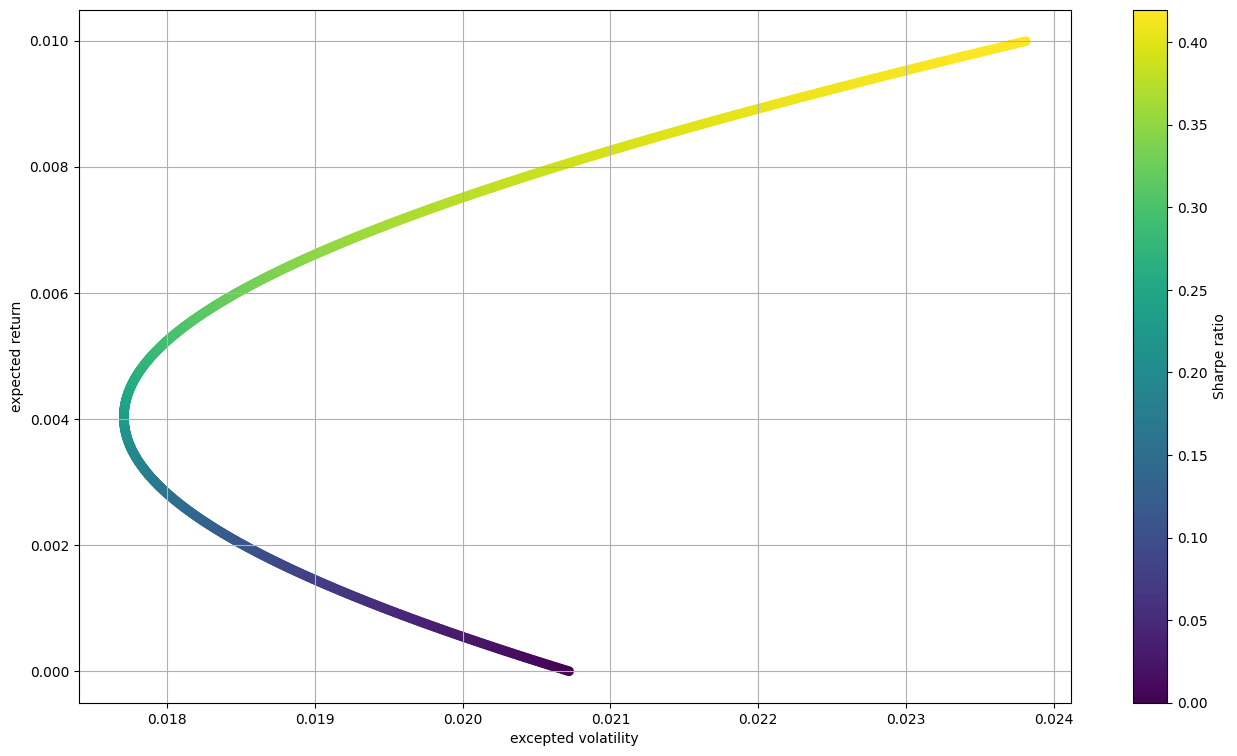

In [21]:
import matplotlib.pyplot as plt

port_ret = []
port_std = []
# 收益率从0到1，步长为0.00001，一共10万个收益率样本
ranges = np.arange(0,0.01, 0.00001)
for i in ranges:
    weight = mini_vol(10, ret_ave1, ret_cov1, i)
    port_ret1, port_std1 = port_info(weight, ret_ave1, ret_cov1)
    port_ret.append(port_ret1)
    port_std.append(port_std1)

port_std = np.array(port_std)
port_ret = np.array(port_ret)
plt.figure(figsize = (16,9))
plt.scatter(port_std,port_ret,c = port_ret/port_std, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')        

In [6]:
import numpy as np

# Re-define the parameters from the user's formula
# Expected returns and covariance matrix (use the previously calculated values)

# exp_returns = np.array([0.0032000496744505375, 0.003531587545669318, -0.0004536124994640622, 
#                         0.0009546910435873468, -0.001564823561311072, 0.017972290896872786, 
#                         -0.001731105171900349, 0.004863581821097423, -0.004512878165519318, 
#                         0.0013672993658991625])

# cov_matrix = np.array([[0.0018343373800826107, 0.000213, 0.000948, 0.000785, 0.000583, 0.000857, 0.000924, 0.000414, 0.000857, 0.000541],
#                        [0.000213, 0.0007842948937087591, 0.000587, 0.000276, 0.000295, 0.000182, 0.00036, -0.000075, 0.000361, 0.000285],
#                        [0.000948, 0.000587, 0.002309350846637749, 0.001179, 0.001385, 0.001176, 0.001311, 0.000051, 0.001083, 0.000686],
#                        [0.000785, 0.000276, 0.001179, 0.0019796597123636853, 0.00085, 0.001039, 0.001118, 0.000489, 0.001031, 0.0008],
#                        [0.000583, 0.000295, 0.001385, 0.00085, 0.0015533816432348132, 0.000664, 0.001106, -0.000096, 0.000919, 0.000569],
#                        [0.000857, 0.000182, 0.001176, 0.001039, 0.000664, 0.003222738166587285, 0.001195, 0.000567, 0.001039, 0.000767],
#                        [0.000924, 0.00036, 0.001311, 0.001118, 0.001106, 0.001195, 0.0015984403806650889, 0.000582, 0.001229, 0.00087],
#                        [0.000414, -0.000075, 0.000051, 0.000489, -0.000096, 0.000567, 0.000582, 0.0009801869886882134, 0.000483, 0.000319],
#                        [0.000857, 0.000361, 0.001083, 0.001031, 0.000919, 0.001039, 0.001229, 0.000483, 0.0021934008504836673, 0.000944],
#                        [0.000541, 0.000285, 0.000686, 0.0008, 0.000569, 0.000767, 0.00087, 0.000319, 0.000944, 0.000913046357894536]])

V_inv = np.linalg.inv(covariances)  # Inverse of the covariance matrix
ones_vector = np.ones(len(expected_returns))  # Vector of ones
kappa = 0.5  # Risk aversion coefficient (from the utility function u = E[R] - kappa * Var[R])

# Calculate alpha and gamma
alpha = np.dot(np.dot(ones_vector.T, V_inv), ones_vector)
gamma = np.dot(np.dot(ones_vector.T, V_inv), expected_returns)

# Calculate the weights of the maximum utility portfolio using the analytical solution
X_p = np.dot(V_inv, expected_returns) / (2 * kappa) - ((gamma - 2 * kappa) * np.dot(V_inv, ones_vector)) / (2 * kappa * alpha)

X_p


array([ 0.4074395 ,  3.51646641, -2.80276585, -0.84053599, -0.75847628,
        6.82511854, -2.55050799,  1.22004971, -0.24515185, -3.77163622])

In [60]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0003812962650436408
       x: [-3.928e-02  4.801e-01 -1.283e-01 -1.843e-01  6.128e-02
            7.852e-02  2.091e-01  4.304e-01 -7.868e-02  1.713e-01]
     nit: 12
     jac: [ 5.271e-04  6.757e-04  4.732e-04  4.387e-04  2.934e-04
            8.025e-04  6.337e-04  7.084e-04  4.274e-04  6.760e-04]
    nfev: 132
    njev: 12